# CreditOne Clasificación

## Introducción

Ahora que se han preparado y explorado adecuadamente los datos a fondo, se comienza con el proceso del modelado. A lo largo de esta tarea, se examinará la selección de características y la construcción de modelos de clasificación mediante el uso del módulo de Python llamado Sci-Kit Learn.

## Seleccionando y Dividiendo los Datos

Inicialmente, se procede a llamar todos los módulos que se necesitan para la realización de la tarea:

In [1]:
# imports
# numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

# estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# model metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score

# cross validation
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

Se importa el conjuto de datos de CreditOne con el preprocesamiento realizando en la tarea anterior:

In [2]:
# data
rawData = pd.read_csv('default of credit card clients.csv', header=1)
rawData.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Se examina la estructura de los datos y se verifica que se importaron en el formato correcto:

In [3]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

Se procede a eliminar del conjunto de datos aquellos atributos que no se tomarán en cuenta para el análisis:

In [4]:
rawData = rawData.drop(columns=['ID', 'SEX'])

Se discretizan las variables 'LIMIT_BAL' y 'AGE':

In [5]:
rawData['LIMIT_BAL'] = pd.cut(x = rawData['LIMIT_BAL'],
                                          bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 10000000],
                                          labels = [1,2,3,4,5,6,7,8,9,10])
rawData['AGE'] = pd.cut(x = rawData['AGE'],
                                          bins = [15, 30, 45, 60, 99],
                                          labels = [1,2,3,4])

Se convierten a variables de tipo nominal o categórica aquellas que lo requieran dentro del conjunto de datos:

In [6]:
rawData = rawData.astype({'EDUCATION': 'category',
                            'MARRIAGE': 'category',
                            'PAY_0': 'category',
                            'PAY_2': 'category',
                            'PAY_3': 'category',
                            'PAY_4': 'category',
                            'PAY_5': 'category',
                            'PAY_6': 'category',
                            'default payment next month': 'category'})
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LIMIT_BAL                   30000 non-null  category
 1   EDUCATION                   30000 non-null  category
 2   MARRIAGE                    30000 non-null  category
 3   AGE                         30000 non-null  category
 4   PAY_0                       30000 non-null  category
 5   PAY_2                       30000 non-null  category
 6   PAY_3                       30000 non-null  category
 7   PAY_4                       30000 non-null  category
 8   PAY_5                       30000 non-null  category
 9   PAY_6                       30000 non-null  category
 10  BILL_AMT1                   30000 non-null  int64   
 11  BILL_AMT2                   30000 non-null  int64   
 12  BILL_AMT3                   30000 non-null  int64   
 13  BILL_AMT4       

### Seleccionando los Datos y Aplicando PCA

Una vez cargado el conjunto de datos, se procede a seleccionar las características con las que se desarrollará el modelo y la variable dependiente:

In [7]:
#features
features_noAMT = rawData.iloc[:,0:10]
print('Summary of feature sample')
features_noAMT.head()

Summary of feature sample


,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,1,2,1,1,2,2,-1,-1,-2,-2
1,2,2,2,1,-1,2,0,0,0,2
2,1,2,2,2,0,0,0,0,0,0
3,1,2,1,2,0,0,0,0,0,0
4,1,2,1,3,-1,0,-1,0,0,0


In [8]:
#dependent variable
depVar = rawData['default payment next month']

Se procede ahora a utilizar PCA con el objetivo de reducir la dimensionalidad del conjunto de datos. Éste análisis se aplica únicamente a los atributos de tipo numérico, con el fin de reducir la cantidad de variables numéricas.

In [9]:
#features
features_AMT = rawData.iloc[:,10:22]
print('Summary of feature sample')
features_AMT.head()

Summary of feature sample


,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


Se decide utilizar un mínimo de número de componentes principales que contengan al menos un 95% de la varianza de la siguiente manera:

In [10]:
# Make an instance of the Model
pca = PCA(.95)

#Fit
pca.fit(features_AMT)

#Transform
features_AMT = pca.transform(features_AMT)

In [11]:
features_AMT_df = pd.DataFrame(features_AMT, columns=['PC0','PC1','PC2','PC3','PC4'])
features_AMT_df.head()

,PC0,PC1,PC2,PC3,PC4
0,-107827.409966,-3025.439711,-2537.615934,-5200.241638,753.913654
1,-104308.440916,2234.471987,-2169.571005,-5041.338555,-176.868674
2,-69249.080182,-3943.555618,-6142.775843,721.904414,1293.421049
3,-15282.889849,-12499.864895,2093.716319,-7442.442119,6520.041355
4,-65854.717174,22834.675392,32156.249549,62.822480,7334.363250


Como resultado, se obtienen 5 componentes principales que representan un 95% de la varianza. Estos se concatenan al conjunto de características separado anteriormente:

In [12]:
features = pd.concat([features_noAMT,features_AMT_df], axis = 1)
features.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PC0,PC1,PC2,PC3,PC4
0,1,2,1,1,2,2,-1,-1,-2,-2,-107827.409966,-3025.439711,-2537.615934,-5200.241638,753.913654
1,2,2,2,1,-1,2,0,0,0,2,-104308.440916,2234.471987,-2169.571005,-5041.338555,-176.868674
2,1,2,2,2,0,0,0,0,0,0,-69249.080182,-3943.555618,-6142.775843,721.904414,1293.421049
3,1,2,1,2,0,0,0,0,0,0,-15282.889849,-12499.864895,2093.716319,-7442.442119,6520.041355
4,1,2,1,3,-1,0,-1,0,0,0,-65854.717174,22834.675392,32156.249549,62.822480,7334.363250


El conjunto de datos se divide en dos partes, un conjunto que contiene los diferentes atributos o variables independientes y otro conjunto que contiene la variable dependiente la cual se quiere predecir. Estos a su vez se dividen en conjuntos de entrenamiento (representando el 70% de los datos) y en conjuntos de prueba (los cuales contienen el 30% restante de los datos).

Se puede realizar una validación cruzada de los conjuntos mediante sklearn.cross_validation de la siguiente manera:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, depVar, test_size=0.30, random_state=0)

También se puede usar la función 'shape' para verificar que la división se realizó según sea necesario:

In [14]:
X_train.shape, X_test.shape

((21000, 15), (9000, 15))

## Construyendo los Modelos y Eligiendo el Modelo Correcto

En esta sección se crean tres modelos de clasificación para seleccionar el adecuado de acuerdo a las necesidades.

Inicialmente, se establecen variables que se utilizarán para definir cada modelo con algunos parametros definidos:

In [15]:
#Models
modelKNN = KNeighborsClassifier(n_neighbors=10, weights='uniform')
modelSVM = SVC(kernel='rbf', gamma='scale')
modelRF = RandomForestClassifier(n_jobs= 10, n_estimators=200, criterion='gini', random_state=0)

Se verifica que la columna correcta se esté utilizando como variable dependiente:

In [16]:
#dependent variable
print(depVar)

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: category
Categories (2, int64): [0, 1]


Se utilizan las variables de modelo que se estableció anteriormente y se transfiere los datos de entrenamiento a todos los modelos de la siguiente manera:

In [17]:
#Random Forest Classifier
modelRF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=10, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
#K-Nearest Neighbors
modelKNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [19]:
#Support Vector Classifier
modelSVM.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Seleccionando el Modelo Correcto

En la mayoría de los casos es necesario la construcción de más de un modelo para encontrar el más apropiado para el trabajo. Sci-Kit Learn tiene una función que 'puntuará' la adecuación de cada modelo según el algoritmo utilizado para construirlo; los modelos con los puntajes más altos deben usarse para hacer predicciones. Como primer parámetro de medición del modelo se procede a obtener el valor del 'cross_val_score' de la siguiente manera:

In [20]:
#Random Forest model
print(cross_val_score(modelRF, X_train, y_train))

[0.8152381  0.81690476 0.80857143 0.80738095 0.81642857]


In [21]:
#Support Vector Classifier model
print(cross_val_score(modelSVM, X_train, y_train)) 

[0.77642857 0.77642857 0.77642857 0.77642857 0.77619048]


In [22]:
#K-Nearest Neighbors model
print(cross_val_score(modelKNN, X_train, y_train)) 

[0.77547619 0.77309524 0.77642857 0.77857143 0.77285714]


A continuación, se procede a puntuar cada uno de los modelos creados:

In [23]:
#Random Forest Model Scoring
modelRF.score(X_train,y_train)

0.9934761904761905

In [24]:
#Support Vector Classifier Model Scoring 
modelSVM.score(X_train,y_train)

0.7764761904761904

In [25]:
#K-Nearest Neighbors Model Scoring
modelKNN.score(X_train,y_train)

0.7931904761904762

## Haciendo las Predicciones y Evaluando los Resultados

### Haciendo las Predicciones

Se lleva a cabo el proceso de predicción utilizando los modelos creados anteriormente:

In [26]:
predictionsRF = modelRF.predict(X_test)
predictionsKNN = modelKNN.predict(X_test)
predictionsSVM = modelSVM.predict(X_test)

### Evaluando los Resultados

En este caso, dado que los modelos realizados corresponden a modelos de clasificación, se tomarán cómo parámetros de medición para elegir al modelo con mejor rendimiento la matriz de confusión, el reporte de clasificación de los resultados y el puntaje de precisión en las predicciones. Estos resultados se muestran a continuación:

In [27]:
#Evaluating K-Nearest Neighbors Model
print("Confusion Matrix")
print(confusion_matrix(y_test, predictionsKNN))
print("Classification Report")
print(classification_report(y_test, predictionsKNN))
print("Accuracy Score")
print(accuracy_score(y_test, predictionsKNN))
print("Kappa")
print(cohen_kappa_score(y_test, predictionsKNN))

Confusion Matrix
[[6874  186]
 [1749  191]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      7060
           1       0.51      0.10      0.16      1940

    accuracy                           0.79      9000
   macro avg       0.65      0.54      0.52      9000
weighted avg       0.73      0.79      0.72      9000

Accuracy Score
0.785
Kappa
0.10186774377212449


In [28]:
#Evaluating Random Forest Model
print("Confusion Matrix")
print(confusion_matrix(y_test, predictionsRF))
print("Classification Report")
print(classification_report(y_test, predictionsRF))
print("Accuracy Score")
print(accuracy_score(y_test, predictionsRF))
print("Kappa")
print(cohen_kappa_score(y_test, predictionsRF))

Confusion Matrix
[[6631  429]
 [1226  714]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7060
           1       0.62      0.37      0.46      1940

    accuracy                           0.82      9000
   macro avg       0.73      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

Accuracy Score
0.8161111111111111
Kappa
0.3610630675149793


In [29]:
#Evaluating Support Vector Classifier Model
print("Confusion Matrix")
print(confusion_matrix(y_test, predictionsSVM))
print("Classification Report")
print(classification_report(y_test, predictionsSVM))
print("Accuracy Score")
print(accuracy_score(y_test, predictionsSVM))
print("Kappa")
print(cohen_kappa_score(y_test, predictionsSVM))

Confusion Matrix
[[7060    0]
 [1940    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7060
           1       0.00      0.00      0.00      1940

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.62      0.78      0.69      9000

Accuracy Score
0.7844444444444445
Kappa
0.0


C:\Users\bsfallas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


De los resultados anteriores, se puede observar que aquel modelo que presenta un mejor rendimiento corresponde al 'Random Forest Classifier' con un 81.2% de precisión en las predicciones y el valor de kappa más alto.

A continuación, se muestra la importancia que le da el modelo a cada una de las variables:

In [30]:
importancesRF = modelRF.feature_importances_
indices = np.argsort(importancesRF)[::-1]
std = np.std([tree.feature_importances_ for tree in modelRF.estimators_],
             axis=0)

Feature ranking:
1. feature 13: PC3 (0.123410)
2. feature 10: PC0 (0.123131)
3. feature 11: PC1 (0.117059)
4. feature 12: PC2 (0.116422)
5. feature 14: PC4 (0.116359)
6. feature 4: PAY_0 (0.106774)
7. feature 5: PAY_2 (0.052598)
8. feature 6: PAY_3 (0.037276)
9. feature 1: EDUCATION (0.033255)
10. feature 0: LIMIT_BAL (0.032570)
11. feature 3: AGE (0.032558)
12. feature 7: PAY_4 (0.030197)
13. feature 9: PAY_6 (0.030029)
14. feature 8: PAY_5 (0.025503)
15. feature 2: MARRIAGE (0.022858)


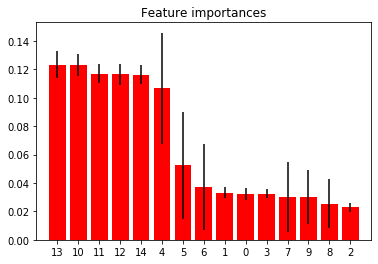

In [31]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], features.columns[indices[f]], importancesRF[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importancesRF[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()